# GAN 101
A simple gan model within TensorFlow r1.10 framework. 

## Import

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
% matplotlib notebook

## Load Data Set

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data(path="mnist.npz")

## Verify data strucutre

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
y_train.shape

(60000,)

## Define model
### Remarks
#### Initialize the variables with caution
In the two loss function defined below, singulars will occur in case the output of the network contains $1$ or $0$, given that the loss function contains the term $\log(x)$ or $\log(1-x)$. In our case the output layer of both generator and discriminator network contains a simgoid function. In $y=sigmoid(wx+b)$, if the weights are too large then the result of this term quickly approaches $0$ or $1$ as $x$ moves away from $0$. Hence the mean and stddev of weight distribution at the output layer are set to $0$ a relatively small value, respectively, to opt out the occurence of singulars in loss functions.  

In [5]:
class GAN:
    def __init__(self, noise_input_tensor, image_input_tensor, generator_hidden_dim, discriminator_hidden_dim):
        self._noise_input = noise_input_tensor
        self._image_input = image_input_tensor
        with tf.variable_scope("generator"):
            self._generator_output, self._generator_parameters = self._fnn(
                noise_input_tensor, generator_hidden_dim, image_input_tensor.shape[1], 
                activation=lambda x: 255 * tf.sigmoid(x)) # (0, 1) -> (0.0, 255.0)
        with tf.variable_scope("discriminator"):
            self._discriminator_output_for_real_data, self._discriminator_parameters = self._fnn(
                image_input_tensor, discriminator_hidden_dim, 1, activation=tf.sigmoid)
        with tf.variable_scope("discriminator", reuse=True):  # Share weights and biases
            d_o_fake = self._discriminator_output_for_synth, _ = self._fnn(self._generator_output, 
                                                                           discriminator_hidden_dim, 
                                                                           1, 
                                                                           activation=tf.sigmoid)
        
    def _fnn(self, input_tensor, hidden_dim, output_dim, activation=None):
        w_xh = tf.get_variable(initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01),
                            shape=[input_tensor.shape[1], hidden_dim], name="W_xh")
        b_xh = tf.get_variable(initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01),
                            shape=[hidden_dim], name="b_xh")
        hidden = tf.nn.relu(tf.add(tf.matmul(input_tensor, w_xh), b_xh))
        w_ho = tf.get_variable(initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01), 
                            shape=[hidden_dim, output_dim], name="W_ho")
        b_ho = tf.get_variable(initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01), 
                            shape=[output_dim], name="b_ho")
        output = tf.add(tf.matmul(hidden, w_ho), b_ho)
        if activation is None:
            return output, (w_xh, b_xh, w_ho, b_ho)
        else:
            return activation(output), (w_xh, b_xh, w_ho, b_ho)
        
        
    @property
    def noise_input(self):
        return self._noise_input
    
    @property
    def image_input(self):
        return self._image_input
    
    @property
    def generator_output(self):
        return self._generator_output

    @property
    def discriminator_output_from_generator(self):
        return self._discriminator_output_for_synth
    
    @property
    def discriminator_output_from_image_input(self):
        return self._discriminator_output_for_real_data
    
    @property
    def g_param(self):
        return self._generator_parameters[:]
    
    @property
    def d_param(self):
        return self._discriminator_parameters[:]

## Specify Dimensions

In [6]:
noise_dim = 128
image_dim = x_train.shape[1] * x_train.shape[2]
generator_hidden_dim = 256
discriminator_hidden_dim = 256

## Create GAN model, define I/O , loss functions and optimizers. 
### Remarks
#### Specifiy the variables to be trained
By default in TensorFlow, all variables are updated by each optimizer, so we need to specify the variables to be trained for each one of the optimizer. In this case we have two optimizers for improving the performance of the generator network and discriminator network, respectively. 

In [7]:
tf.reset_default_graph()
with tf.variable_scope("GAN"):
    generator_input = tf.placeholder(shape=[None, noise_dim], dtype=tf.float32, name="generator_input")
    discriminator_input = tf.placeholder(shape=[None, image_dim], dtype=tf.float32, name="discriminator_input_real")
    gan = GAN(generator_input, discriminator_input, generator_hidden_dim, discriminator_hidden_dim)
    generator_loss = -tf.reduce_mean(tf.log(gan.discriminator_output_from_generator), name="generator_loss")
    discriminator_loss = -tf.reduce_mean(
        tf.log(gan.discriminator_output_from_image_input)+tf.log(1.0-gan.discriminator_output_from_generator), 
        name="discriminator_loss")
with tf.variable_scope("training_configuration"):
    g_learing_rate_tensor = tf.get_variable(dtype=tf.float32, initializer=0.0, name="generator_lr")
    d_learing_rate_tensor = tf.get_variable(dtype=tf.float32, initializer=0.0, name="discriminator_lr")
    global_step = tf.get_variable(dtype=tf.int32, shape=[], name="global_step", trainable=False)
    g_train_op = tf.train.AdamOptimizer(learning_rate=g_learing_rate_tensor).minimize(generator_loss, 
                                                                                       var_list=gan.g_param, 
                                                                                      global_step=global_step)
    d_train_op = tf.train.AdamOptimizer(learning_rate=d_learing_rate_tensor).minimize(discriminator_loss, 
                                                                                      var_list=gan.d_param, global_step=global_step)
    
    summary_gen_loss = tf.summary.scalar(tensor=generator_loss, name="generator_loss_summary")
    summary_dis_loss = tf.summary.scalar(tensor=generator_loss, name="discriminator_loss_summary")
    summary_all = tf.summary.merge_all()

## Prepare Dataset and Start Training

In [8]:
with tf.variable_scope("training_configuration", auxiliary_name_scope=False): # Re-entering the name scope
    batch_size_t = tf.placeholder(dtype=tf.int64, shape=[], name="batch_size")
    training_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    training_set = training_set.batch(batch_size=batch_size_t)
    batch_iter_train = training_set.make_initializable_iterator()
    next_batch_train = batch_iter_train.get_next()

In [9]:
n_epoch = 100
batch_size = 50
g_lr, d_lr = 2e-5, 2e-5
lr_decay = 0.97
num_batch = int(x_train.shape[0]/batch_size)
k = 1
model_param_path = os.path.normpath(r"./model_checkpoints")
saver=tf.train.Saver()
with tf.Session() as sess, tf.summary.FileWriter(logdir=model_param_path) as writer:
    writer.add_graph(graph=tf.get_default_graph())
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epoch):
        sess.run([tf.assign(g_learing_rate_tensor, g_lr), tf.assign(d_learing_rate_tensor, d_lr)])
        sess.run(batch_iter_train.initializer, feed_dict={batch_size_t: batch_size})
        for batch_no in range(num_batch):
            x, _ = sess.run(next_batch_train)
            x = x.reshape([-1, image_dim]) # flatten each sample manually
            # Train the discriminator network k times
            for _ in range(k):
                noise_batch = np.random.uniform(-1.0, 1.0, size=[batch_size, noise_dim])
                feed_dict = {gan.image_input: x, gan.noise_input: noise_batch}
                sess.run(d_train_op, feed_dict=feed_dict)
            # Train the generator network once
            noise_batch = np.random.uniform(-1.0, 1.0, size=[batch_size, noise_dim])
            feed_dict = {gan.image_input: x, gan.noise_input: noise_batch}
            _, summary, step = sess.run([g_train_op, summary_all, global_step], feed_dict=feed_dict)
            writer.add_summary(summary=summary, global_step=step)
        g_lr = g_lr * lr_decay
        d_lr = d_lr * lr_decay
    saver.save(sess=sess, save_path=os.path.join(model_param_path, "GAN"))
print("Done!")

Done!


## Test Network

INFO:tensorflow:Restoring parameters from model_checkpoints/GAN


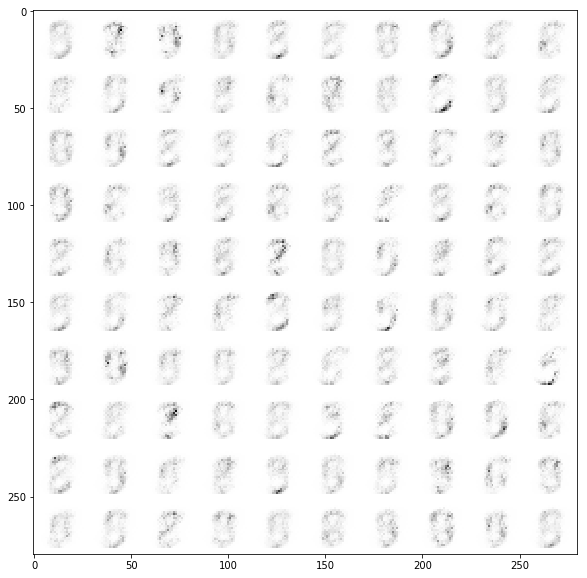

In [12]:
n = 10
canvas = np.empty((28 * n, 28 * n))
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state(model_param_path)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        for i in range(n):
            # Noise input.
            z = np.random.uniform(-1., 1., size=[n, noise_dim])
            # Generate image from noise.
            g = sess.run(gan.generator_output, feed_dict={gan.noise_input: z})
            # Reverse colours for better display
            # g = -1 * (g - 1)
            g = -1 * (g - 255)
            g = g.astype(np.int32)
            for j in range(n):
                # Draw the generated digits
                canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])
        plt.figure(figsize=(n, n))
        plt.imshow(canvas, origin="upper", cmap="gray")
        plt.show()
    else:
        print("Failed to load model checkpoint.")